# Import lib

In [16]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import datetime
import copy
import csv

# *** Library ***
sys.path.append('./lib/')
import juice_cdf_lib as juice_cdf
import juice_sid2_lib as juice_sid2

class struct:
    pass

In [17]:
# Latest CDF library: https://spdf.gsfc.nasa.gov/pub/software/cdf/dist/latest/
from spacepy import pycdf

# os.environ["CDF_LIB"] = "C:\\Program Files\\CDF_Distribution\\cdf39_0-dist\\lib"
os.environ["CDF_LIB"] = "/Applications/cdf/cdf39_0-dist/lib"

# *** Folder set ***
work_dir = '/Users/user/0-python/JUICE_GS_test/ql/sid2/'    # Plot dump folder
data_dir = '/Users/user/0-python/JUICE_GS_test/cdf/'        # Data folder

# Setting and Read CDF file

In [18]:
# *** Mode set ***
hz_mode = 0                             # 0: sum    1: /Hz
cal_mode = 0                            # 0: raw    1: dBm＠ADC  2: V@HF   3:V2@HF   4:V2@RWI
#
spec_mode = 1                           # 0: low-resoltion   1: high-resolution
ave_mode = 1                            # 0: simple sum   1: FFT sum   2: median sum   3: min sum
clean_mode = 0                          # 0: normal 1: cleaning in time   2: cleaning in time & frequency

# *** Parameter set ***
cal = 0                                 # 0: background   1: cal
f_max = 45000                           # f_max [kHz]
f_min = 80                              # f_min [kHz]
p_max = 8.5                             # background: 8     CAL: 10
p_min = 1.5                             # background: 2.5   CAL: 5

In [19]:
# *** Conversion factor: cal_mode ***
cf = 0.0                                # Conversion Factor: RAW
if cal_mode == 1:
    cf = -104.1                         # dBm @ ADC 
elif cal_mode == 2:
    cf = -104.1 - 10.00 - 15.0          # V(amplitude) @ HF -- in EM2-1: HF-gain +15dB, ADC: 2Vpp  ==> EM2-3 & later: same [-6dB + 6dB]
elif cal_mode == 3:
    cf = -104.1 - 13.01 - 15.0          # V^2 @ HF (EM2-0 case)
elif cal_mode == 4:
    cf = -104.1 - 13.01 - 15.0 - 5.0    # V^2 @ RWIin -- temporary
# ******************************************************
# [EM2-0]
# "1-bit" = -104.1 dBm = -114.1 dB V  = 1.97E-6 V    ==> "20-bit": 2.06 Vpp
# "HF input"  +15dB(AMP) -3dB(50-ohm) = "+12dB"      ==> "1-bit": 5E-7 V,  Full: 0.5 Vpp
# ******************************************************
# [EM2-3]
# "1-bit" = -110.1 dBm = -110.1 dB V  = 0.99E-7 V "  ==> "20-bit": 1.03 Vpp
# "HF input"  +9dB(AMP)  -3dB(50-ohm受け) = "+6dB"    ==> "1-bit": 5E-7 V,  Full: 0.5 Vpp
# ******************************************************

# *** Max / Min in plots ***
p_max = p_max + cf/10
p_min = p_min + cf/10
if hz_mode == 1:
    p_max = p_max - 5.0
    p_min = p_min - 5.0
else:
    if spec_mode == 1:
        p_max = p_max - 1.5
        p_min = p_min - 1.5

In [20]:
# *** Flight - Ver.1

# *** 20230419 ***
data_name = '202304/JUICE_L1a_RPWI-HF-SID2_20230419T135849-20230419T141229_V01___RPR1_52000000_2023.109.16.17.21.607.cdf'
#data_name = '202304/JUICE_L1a_RPWI-HF-SID2_20230419T141231-20230419T141402_V01___RPR1_52000001_2023.109.17.51.54.600.cdf'
# data_name = '202304/JUICE_L1a_RPWI-HF-SID2_20230419T135849-20230419T141402_V01___HF_2023.109.cdf'

# *** 20230530 ***
#data_name = 'JUICE_L1a_RPWI-HF-SID2_20230530T100326-20230530T100925_V01___RPR1_52000010_2023.150.10.40.53.663.cdf'
#data_name = 'JUICE_L1a_RPWI-HF-SID2_20230530T100927-20230530T100937_V01___RPR1_52000011_2023.150.10.41.53.508.cdf'
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20230530T100326-20230530T100937_V01___HF_2023.150.cdf'

# *** 20230601 ***
#data_name = 'JUICE_L1a_RPWI-HF-SID2_20230601T120759-20230601T120857_V01___RPR1_52000015_2023.152.12.32.12.471.cdf'
#data_name = 'JUICE_L1a_RPWI-HF-SID2_20230601T121435-20230601T121533_V01___RPR1_52000016_2023.152.13.14.38.473.cdf'
#data_name = 'JUICE_L1a_RPWI-HF-SID2_20230601T122138-20230601T122236_V01___RPR1_52000017_2023.152.13.55.02.539.cdf'
#data_name = 'JUICE_L1a_RPWI-HF-SID2_20230601T122707-20230601T122805_V01___RPR1_52000018_2023.152.14.35.37.467.cdf'
#data_name = 'JUICE_L1a_RPWI-HF-SID2_20230601T123416-20230601T123514_V01___RPR1_52000019_2023.152.15.15.55.483.cdf'
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20230601T120759-20230601T123514_V01___HF_2023.152.cdf'

# *** 20230712-13 ***
#data_name = 'JUICE_L1a_RPWI-HF-SID2_20230712T090434-20230712T093848_V01___RPR1_52000001_2023.193.10.24.57.479.cdf'
#data_name = 'JUICE_L1a_RPWI-HF-SID2_20230712T093942-20230712T101355_V01___RPR1_52000002_2023.194.08.38.36.474.cdf'
#data_name = 'JUICE_L1a_RPWI-HF-SID2_20230712T101449-20230712T104147_V01___RPR1_52000003_2023.194.10.18.44.478.cdf'
#   data_name = 'JUICE_L1a_RPWI-HF-SID2_20230712T090434-20230712T104147_V01___HF_2023.194.cdf'
#
#   data_name = 'JUICE_L1a_RPWI-HF-SID2_20230712T104149-20230712T232406_V01___RPR1_52000004_2023.194.11.15.35.498.cdf'
#
#data_name = 'JUICE_L1a_RPWI-HF-SID2_20230712T232408-20230712T235156_V01___RPR1_52000005_2023.195.09.10.17.486.cdf'
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20230712T235158-20230713T001854_V01___RPR1_52000006_2023.195.10.28.57.506.cdf'
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20230713T001856-20230713T004644_V01___RPR1_52000007_2023.195.11.42.37.540.cdf'
#data_name = 'JUICE_L1a_RPWI-HF-SID2_20230713T004648-20230713T011342_V01___RPR1_52000008_2023.195.12.39.02.479.cdf'
#data_name = 'JUICE_L1a_RPWI-HF-SID2_20230713T011436-20230713T014134_V01___RPR1_52000009_2023.195.13.03.08.470.cdf'
#data_name = 'JUICE_L1a_RPWI-HF-SID2_20230713T014136-20230713T020924_V01___RPR1_5200000A_2023.195.13.25.22.477.cdf'
#data_name = 'JUICE_L1a_RPWI-HF-SID2_20230713T020928-20230713T023718_V01___RPR1_5200000B_2023.195.13.47.46.500.cdf'
#data_name = 'JUICE_L1a_RPWI-HF-SID2_20230713T023720-20230713T030416_V01___RPR1_5200000C_2023.195.14.10.35.574.cdf'
#data_name = 'JUICE_L1a_RPWI-HF-SID2_20230713T030510-20230713T033208_V01___RPR1_5200000D_2023.195.14.33.20.470.cdf'
#data_name = 'JUICE_L1a_RPWI-HF-SID2_20230713T033210-20230713T040000_V01___RPR1_5200000E_2023.195.14.55.41.474.cdf'
#data_name = 'JUICE_L1a_RPWI-HF-SID2_20230713T040002-20230713T042751_V01___RPR1_5200000F_2023.195.15.18.00.472.cdf'
#data_name = 'JUICE_L1a_RPWI-HF-SID2_20230713T042753-20230713T045449_V01___RPR1_52000010_2023.195.15.40.11.470.cdf'
#data_name = 'JUICE_L1a_RPWI-HF-SID2_20230713T045543-20230713T050917_V01___RPR1_52000011_2023.195.16.14.20.468.cdf'
#    data_name = 'JUICE_L1a_RPWI-HF-SID2_20230712T232408-20230713T050917_V01___HF_2023.195.cdf'


In [21]:
# *** Prelaunch - Ver.1 ***

# *** 20210531 ***
#data_name = 'prelaunch/JUICE_L1a_RPWI-HF-SID2_20210531_20510511T104512-20210531_20510511T104623_V01___20210531_SCPFM_PTR_RPWI_2_day3_xid32770.data.hf.ccsds.cdf'
#data_name = 'prelaunch/JUICE_L1a_RPWI-HF-SID2_20210531_20510511T104625-20510511T104805_V01___20210531_SCPFM_PTR_RPWI_2_day3_xid32774.data.hf.ccsds.cdf'
#data_name = 'prelaunch/JUICE_L1a_RPWI-HF-SID2_20210531_20510511T104809-20510511T104948_V01___20210531_SCPFM_PTR_RPWI_2_day3_xid32775.data.hf.ccsds.cdf'
#data_name = 'prelaunch/JUICE_L1a_RPWI-HF-SID2_20210531_20510511T104950-20510511T105129_V01___20210531_SCPFM_PTR_RPWI_2_day3_xid32776.data.hf.ccsds.cdf'
#data_name = 'prelaunch/JUICE_L1a_RPWI-HF-SID2_20210531_20510511T105133-20510511T105311_V01___20210531_SCPFM_PTR_RPWI_2_day3_xid32777.data.hf.ccsds.cdf'
#data_name = 'prelaunch/JUICE_L1a_RPWI-HF-SID2_20210531_20510511T105313-20510511T105313_V01___20210531_SCPFM_PTR_RPWI_2_day3_xid32778.data.hf.ccsds.cdf'
#data_name = 'prelaunch/JUICE_L1a_RPWI-HF-SID2_20210531_20510517T105949-20510517T110027_V01___20210531_SCPFM_PTR_RPWI_2_day5_xid32772.data.hf.ccsds.cdf'
#data_name = 'prelaunch/JUICE_L1a_RPWI-HF-SID2_20210531_20510517T110029-20510517T110209_V01___20210531_SCPFM_PTR_RPWI_2_day5_xid32773.data.hf.ccsds.cdf'
#data_name = 'prelaunch/JUICE_L1a_RPWI-HF-SID2_20210531_20510517T110211-20510517T110351_V01___20210531_SCPFM_PTR_RPWI_2_day5_xid32774.data.hf.ccsds.cdf'
#data_name = 'prelaunch/JUICE_L1a_RPWI-HF-SID2_20210531_20510517T110353-20510517T110533_V01___20210531_SCPFM_PTR_RPWI_2_day5_xid32775.data.hf.ccsds.cdf'
#data_name = 'prelaunch/JUICE_L1a_RPWI-HF-SID2_20210531_20510517T110535-20510517T110716_V01___20210531_SCPFM_PTR_RPWI_2_day5_xid32776.data.hf.ccsds.cdf'
#data_name = 'prelaunch/JUICE_L1a_RPWI-HF-SID2_20210531_20510517T110718-20510517T110732_V01___20210531_SCPFM_PTR_RPWI_2_day5_xid32777.data.hf.ccsds.cdf'

# *** 20210600 ***
#data_name = 'prelaunch/JUICE_L1a_RPWI-HF-SID2_20210600_20510630T194327-20510630T194443_V01___SCTBTV_Phase11_xid32831.data.hf.ccsds.cdf'
#data_name = 'prelaunch/JUICE_L1a_RPWI-HF-SID2_20210600_20510630T194445-20510630T194806_V01___SCTBTV_Phase11_xid32832.data.hf.ccsds.cdf'
#data_name = 'prelaunch/JUICE_L1a_RPWI-HF-SID2_20210600_20510630T194808-20510630T195127_V01___SCTBTV_Phase11_xid32833.data.hf.ccsds.cdf'
#data_name = 'prelaunch/JUICE_L1a_RPWI-HF-SID2_20210600_20510630T195129-20510630T195129_V01___SCTBTV_Phase11_xid32834.data.hf.ccsds.cdf'
#data_name = 'prelaunch/JUICE_L1a_RPWI-HF-SID2_20210600_20510709T102540-20510709T102649_V01___SCTBTV_Phase13_xid32844.data.hf.ccsds.cdf'
#data_name = 'prelaunch/JUICE_L1a_RPWI-HF-SID2_20210600_20510709T102651-20510709T103011_V01___SCTBTV_Phase13_xid32845.data.hf.ccsds.cdf'
#data_name = 'prelaunch/JUICE_L1a_RPWI-HF-SID2_20210600_20510709T103013-20510709T103333_V01___SCTBTV_Phase13_xid32846.data.hf.ccsds.cdf'

# *** 20221100 ***
#data_name = 'prelaunch/JUICE_L1a_RPWI-HF-SID2_20211100_20511125T233551-20511125T233702_V01___SCPFM_PTR_RPWI_delta.RPWI_SCM_TEST_xid32770.data.hf.ccsds.cdf'
#data_name = 'prelaunch/JUICE_L1a_RPWI-HF-SID2_20211100_20511125T233704-20511125T234024_V01___SCPFM_PTR_RPWI_delta.RPWI_SCM_TEST_xid32771.data.hf.ccsds.cdf'
# data_name = 'prelaunch/JUICE_L1a_RPWI-HF-SID2_20211100_20511125T234026-20511125T234338_V01___SCPFM_PTR_RPWI_delta.RPWI_SCM_TEST_xid32772.data.hf.ccsds.cdf'

# *** 20220700 ***
# data_name = 'prelaunch/JUICE_L1a_RPWI-HF-SID2_20220700_20520714T133155-20520714T133319_V01___SCPFM_RPWI_30c_xid32776.data.hf.ccsds.cdf'
# data_name = 'prelaunch/JUICE_L1a_RPWI-HF-SID2_20220700_20520714T133321-20520714T133640_V01___SCPFM_RPWI_30c_xid32777.data.hf.ccsds.cdf'
# data_name = 'prelaunch/JUICE_L1a_RPWI-HF-SID2_20220700_20520714T133642-20520714T134002_V01___SCPFM_RPWI_30c_xid32778.data.hf.ccsds.cdf'
# data_name = 'prelaunch/JUICE_L1a_RPWI-HF-SID2_20220700_20520714T134004-20520714T134028_V01___SCPFM_RPWI_30c_xid32779.data.hf.ccsds.cdf'

# *** 20220824 ***
# data_name = 'prelaunch/JUICE_L1a_RPWI-HF-SID2_20220824_20520823T141802-20520823T141911_V01___HF-FFT-rerun_xid32791.data.hf.ccsds.cdf'
# data_name = 'prelaunch/JUICE_L1a_RPWI-HF-SID2_20220824_20520823T141913-20520823T142233_V01___HF-FFT-rerun_xid32792.data.hf.ccsds.cdf'
# data_name = 'prelaunch/JUICE_L1a_RPWI-HF-SID2_20220824_20520823T142235-20520823T142549_V01___HF-FFT-rerun_xid32793.data.hf.ccsds.cdf'

# *** Test - Ver.1 ***
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20000101T000304-20000101T000308_V01___TMIDX_00000_32.bin.cdf'
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20000101T000150-20000101T000154_V01___TMIDX_00000_64.bin.cdf'
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20000101T000355-20000101T000359_V01___TMIDX_00000_96.bin.cdf'
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20000101T000555-20000101T000559_V01___TMIDX_00000_128.bin.cdf'
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20000101T000725-20000101T000730_V01___TMIDX_00000_256.bin.cdf'
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20000101T000131-20000101T000139_V01___TMIDX_00000_512.bin.cdf'
#
# data_name = 'bad_NEW_PROCESSING_JUICE_L1a_RPWI-HF-SID2_20000101T000114-20000101T000210_V01___TMIDX_00000.bin.cdf'

#data_name = 'JUICE_L1a_RPWI-HF-SID2_20000101T000050-20000101T000454_V01___HF_SID2_032_20230624-1132.ccs.cdf'
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20000101T000031-20000101T000940_V01___HF_SID2_064_20230624-1139.ccs.cdf'
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20000101T000111-20000101T000150_V01___HF_SID2_128_20230624-1306.ccs.cdf'


In [22]:
# *** Ver.2 ***

# *** Tsuchiya ***
# data_name = 'ver2_sample/tsuchiya/JUICE_L1a_RPWI-HF-SID2_20000101T000459-20000101T000700_V01___HF_20210920-1007.ccs.cdf'


# get SID-2 data

In [23]:
cdf_file = data_dir + data_name
%ls $cdf_file

cdf = pycdf.CDF(cdf_file)
data = juice_sid2.hf_sid02_getdata(cdf)
date = data.epoch[0]
month = date.strftime('%Y%m')
print(data.epoch[0], "-", data.epoch[-1], "[", month, "]")

### SPECIAL: 202305 -- data shift -16
if month == "202305":
    data.Eu_i = np.roll(data.Eu_i, -16)
    data.Eu_q = np.roll(data.Eu_q, -16)
    data.Ev_i = np.roll(data.Ev_i, -16)
    data.Ev_q = np.roll(data.Ev_q, -16)
    data.Ew_i = np.roll(data.Ew_i, -16)
    data.Ew_q = np.roll(data.Ew_q, -16)
    print("-16 shift in 202305 data")
### SPECIAL: 202305 -- data shift -16

### SPECIAL: 202307 -- data shift -16
if month == "202307":
    data.Eu_i = np.roll(data.Eu_i, -16)
    data.Eu_q = np.roll(data.Eu_q, -16)
    data.Ev_i = np.roll(data.Ev_i, -16)
    data.Ev_q = np.roll(data.Ev_q, -16)
    data.Ew_i = np.roll(data.Ew_i, -16)
    data.Ew_q = np.roll(data.Ew_q, -16)
    print("-16 shift in 202307 data")
### SPECIAL: 202307 -- data shift -16

/Users/user/0-python/JUICE_GS_test/cdf/202304/JUICE_L1a_RPWI-HF-SID2_20230419T135849-20230419T141229_V01___RPR1_52000000_2023.109.16.17.21.607.cdf


2023-04-19 13:58:49.930176 - 2023-04-19 14:12:29.752869 [ 202304 ]


# Raw data

2023/04/19


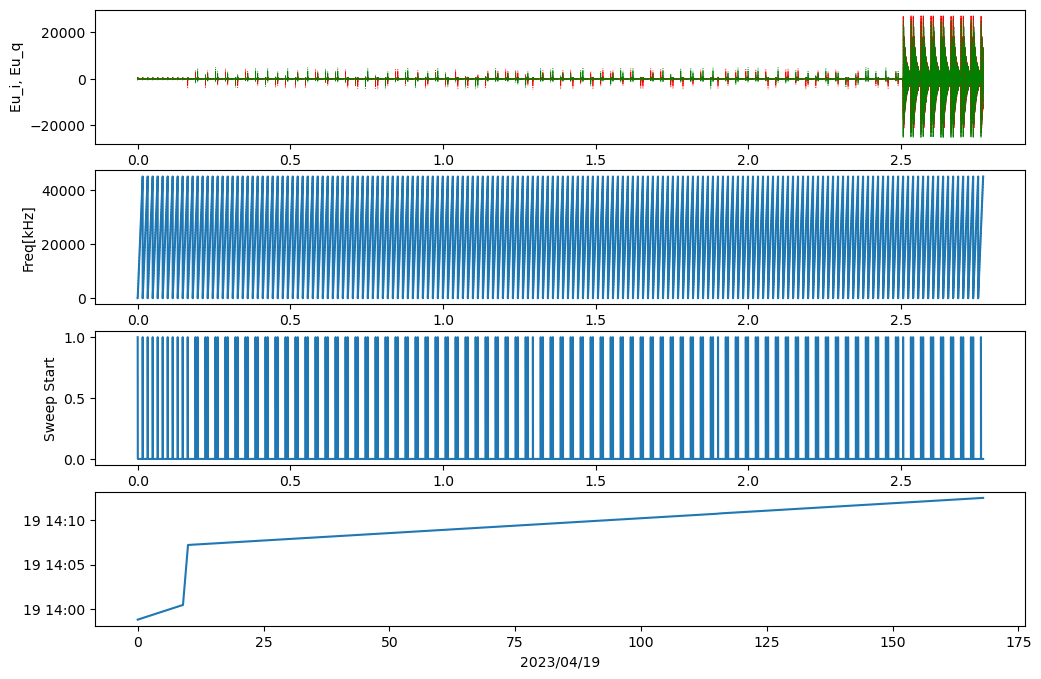

In [24]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(4, 1, 1)
ax2 = fig.add_subplot(4, 1, 2)
ax3 = fig.add_subplot(4, 1, 3)
ax4 = fig.add_subplot(4, 1, 4)

ax1.plot(np.ravel(data.Eu_i), '-r', linewidth=.5)
ax1.plot(np.ravel(data.Eu_q), '-g', linewidth=.5)
ax1.plot(np.ravel(data.Ev_i), '--r', linewidth=.5)
ax1.plot(np.ravel(data.Ev_q), '--g', linewidth=.5)
ax1.plot(np.ravel(data.Ew_i), ':r', linewidth=.5)
ax1.plot(np.ravel(data.Ew_q), ':g', linewidth=.5)
ax2.plot(np.ravel(data.frequency))
ax3.plot(np.ravel(data.sweep_start))
ax4.plot(np.ravel(data.epoch))
#
date = data.epoch[0]
date = date.strftime('%Y/%m/%d')
print(date)

ax1.set_ylabel('Eu_i, Eu_q')
ax2.set_ylabel('Freq[kHz]')
ax3.set_ylabel('Sweep Start')
ax4.set_xlabel(date)

"""
# SPECIAL -- data check
# X-axis
xlim=[490*32-1, 491*32+1]
ax1.set_xlim(xlim)
ax2.set_xlim(xlim)
ax3.set_xlim(xlim)
#
# Y-axis
ylim=[-2000, +2000]
ax1.set_ylim(ylim)
# SPECIAL -- data check
"""

# Plot
plt.show()
png_fname = work_dir+data_name+'_raw.png'
# fig.savefig(png_fname)

In [25]:
# Spec mode:           0: low resolution  1; high resolution  
spec = juice_sid2.hf_sid02_getspec(data, spec_mode, hz_mode, ave_mode)
power_str = juice_cdf.power_label(cal_mode, hz_mode)
#
n_time = spec.Eu_power.shape[1]
n_freq = spec.Eu_power.shape[0]
print("n_time:", n_time)
print("n_freq:", n_freq, n_freq/512)

# cf: Conversion factor
spec.Eu_power = spec.Eu_power * 10**(cf/10)
spec.Ev_power = spec.Ev_power * 10**(cf/10)
spec.Ew_power = spec.Ew_power * 10**(cf/10)

****ERROR**** [ 10 10 2023-04-19 14:07:12.815048 ] length: 25600 != 32 * 512
****ERROR**** [ 11 10 2023-04-19 14:07:14.756134 ] length: 7168 != 32 * 512
****ERROR**** [ 12 10 2023-04-19 14:07:16.815018 ] length: 25600 != 32 * 512
****ERROR**** [ 13 10 2023-04-19 14:07:18.756088 ] length: 7168 != 32 * 512
****ERROR**** [ 14 10 2023-04-19 14:07:20.814957 ] length: 25600 != 32 * 512
****ERROR**** [ 15 10 2023-04-19 14:07:22.756042 ] length: 7168 != 32 * 512
****ERROR**** [ 16 10 2023-04-19 14:07:24.814926 ] length: 25600 != 32 * 512
****ERROR**** [ 17 10 2023-04-19 14:07:26.756012 ] length: 7168 != 32 * 512
****ERROR**** [ 18 10 2023-04-19 14:07:28.814896 ] length: 25600 != 32 * 512
****ERROR**** [ 19 10 2023-04-19 14:07:30.755966 ] length: 7168 != 32 * 512
****ERROR**** [ 20 10 2023-04-19 14:07:32.814835 ] length: 25600 != 32 * 512
****ERROR**** [ 21 10 2023-04-19 14:07:34.755920 ] length: 7168 != 32 * 512
****ERROR**** [ 22 10 2023-04-19 14:07:36.814804 ] length: 25600 != 32 * 512
****E

In [26]:
# Median Filter

In [27]:
df = 13    # frequency filter width / 2
dt = 13    # time filter width / 2

# Noise cleaning -- in frequency
if clean_mode == 2:   # 2: frequency cleaning
    Eu_power = copy.copy(spec.Eu_power)
    Ev_power = copy.copy(spec.Ev_power)
    Ew_power = copy.copy(spec.Ew_power)

    for i in range(n_time):
        for j in range(n_freq):
            j1 = j - df
            if j1 < 0:
                j1 = 0
            j2 = j + df
            if j2 > n_freq-1:
                i2 = n_freq-1
            Eu_power[j,i] = np.median(spec.Eu_power[j1:j2,i])
            Ev_power[j,i] = np.median(spec.Ev_power[j1:j2,i])
            Ew_power[j,i] = np.median(spec.Ew_power[j1:j2,i])
    spec.Eu_power = copy.copy(Eu_power)
    spec.Ev_power = copy.copy(Ev_power)
    spec.Ew_power = copy.copy(Ew_power)

# all median
freq_med = np.median(spec.frequency, axis=1)
Eu_med = np.median(spec.Eu_power, axis=1)
Ev_med = np.median(spec.Ev_power, axis=1)
Ew_med = np.median(spec.Ew_power, axis=1)

# Noise cleaning -- in time
spec_bg = copy.deepcopy(spec)
spec_norm = copy.deepcopy(spec)
spec_diff = copy.deepcopy(spec)

if clean_mode > 0:   # 1: noise cleaning in time
    for i in range(n_time):
        for j in range(n_freq):
            i1 = i - dt
            if i1 < 0:
                i1 = 0
            i2 = i + dt
            if i2 > n_time-1:
                i2 = n_time-1
            spec_bg.Eu_power[j,i] = np.median(spec.Eu_power[j,i1:i2])
            spec_bg.Ev_power[j,i] = np.median(spec.Ev_power[j,i1:i2])
            spec_bg.Ew_power[j,i] = np.median(spec.Ew_power[j,i1:i2])

    # Normalized
    spec_norm.Eu_power = spec.Eu_power / spec_bg.Eu_power
    spec_norm.Ev_power = spec.Ev_power / spec_bg.Ev_power
    spec_norm.Ew_power = spec.Ew_power / spec_bg.Ew_power

    # Diff
    spec_diff.Eu_power = spec.Eu_power - spec_bg.Eu_power
    spec_diff.Ev_power = spec.Ev_power - spec_bg.Ev_power
    spec_diff.Ew_power = spec.Ew_power - spec_bg.Ew_power
    spec_diff.Eu_power[spec_diff.Eu_power < 0] = 0.01
    spec_diff.Ev_power[spec_diff.Ev_power < 0] = 0.01
    spec_diff.Ew_power[spec_diff.Ew_power < 0] = 0.01

# Spectra

# LOG: Frequency - Power

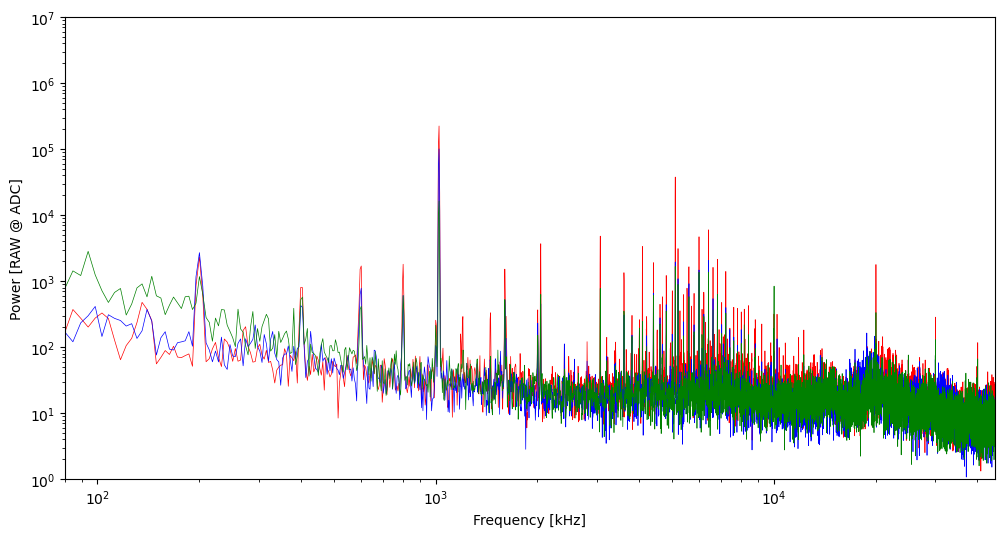

In [28]:
fig = plt.figure(figsize=(12, 6))
plt.plot(freq_med, Eu_med, '-r', linewidth=.5)
plt.plot(freq_med, Ev_med, '-b', linewidth=.5)
plt.plot(freq_med, Ew_med, '-g', linewidth=.5)
"""
plt.plot(spec.frequency[:,0], spec.Eu_power[:,0], '--r', linewidth=.5)
plt.plot(spec.frequency[:,0], spec.Ev_power[:,0], '--b', linewidth=.5)
plt.plot(spec.frequency[:,0], spec.Ew_power[:,0], '--g', linewidth=.5)
plt.plot(spec.frequency[:,n_time-1], spec.Eu_power[:,n_time-1], ':r', linewidth=.5)
plt.plot(spec.frequency[:,n_time-1], spec.Ev_power[:,n_time-1], ':b', linewidth=.5)
plt.plot(spec.frequency[:,n_time-1], spec.Ew_power[:,n_time-1], ':g', linewidth=.5)
"""

plt.xscale('log')
plt.yscale('log')
plt.xlim(f_min, f_max)
plt.ylim(10**p_min, 10**p_max)

plt.xlabel('Frequency [kHz]')
plt.ylabel(power_str)

plt.show()
png_fname = work_dir+data_name+'_spec-log.png'
if (spec_mode>0):
    png_fname = work_dir+data_name+'_spec-log_h.png'
fig.savefig(png_fname)

# Linear: Frequency - Power

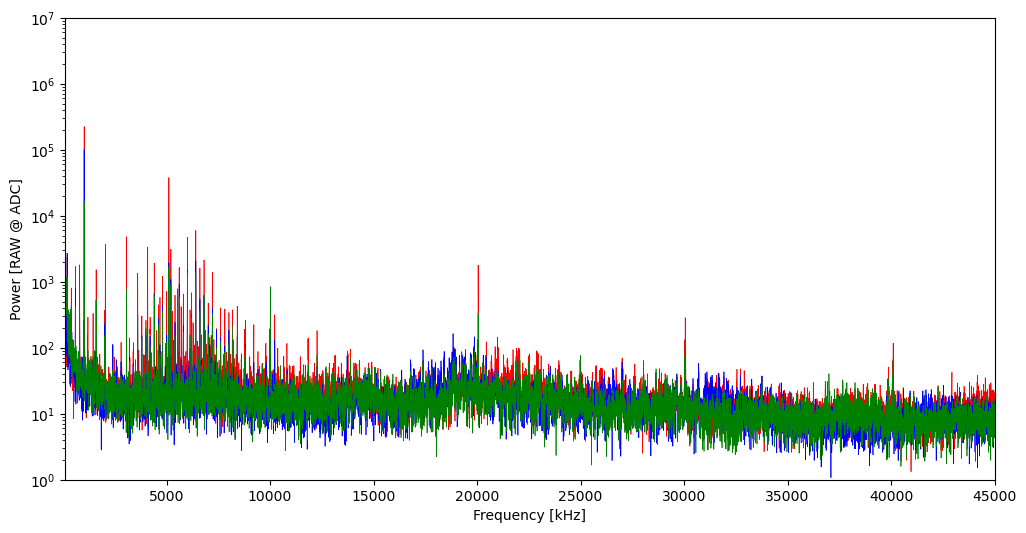

In [29]:
fig = plt.figure(figsize=(12, 6))

plt.plot(freq_med, Eu_med, '-r', linewidth=.5)
plt.plot(freq_med, Ev_med, '-b', linewidth=.5)
plt.plot(freq_med, Ew_med, '-g', linewidth=.5)
"""
plt.plot(spec.frequency[:,0], spec.Eu_power[:,0], '--r', linewidth=.5)
plt.plot(spec.frequency[:,0], spec.Ev_power[:,0], '--b', linewidth=.5)
plt.plot(spec.frequency[:,0], spec.Ew_power[:,0], '--g', linewidth=.5)
plt.plot(spec.frequency[:,n_time-1], spec.Eu_power[:,n_time-1], ':r', linewidth=.5)
plt.plot(spec.frequency[:,n_time-1], spec.Ev_power[:,n_time-1], ':b', linewidth=.5)
plt.plot(spec.frequency[:,n_time-1], spec.Ew_power[:,n_time-1], ':g', linewidth=.5)
"""

# plt.xscale('log')
plt.yscale('log')
plt.xlim(f_min, f_max)
plt.ylim(10**p_min, 10**p_max)

plt.xlabel('Frequency [kHz]')
plt.ylabel(power_str)

plt.show()
png_fname = work_dir+data_name+'_spec.png'
if (spec_mode>0):
    png_fname = work_dir+data_name+'_spec_h.png'
# fig.savefig(png_fname)

# LOG: Frequency - Time

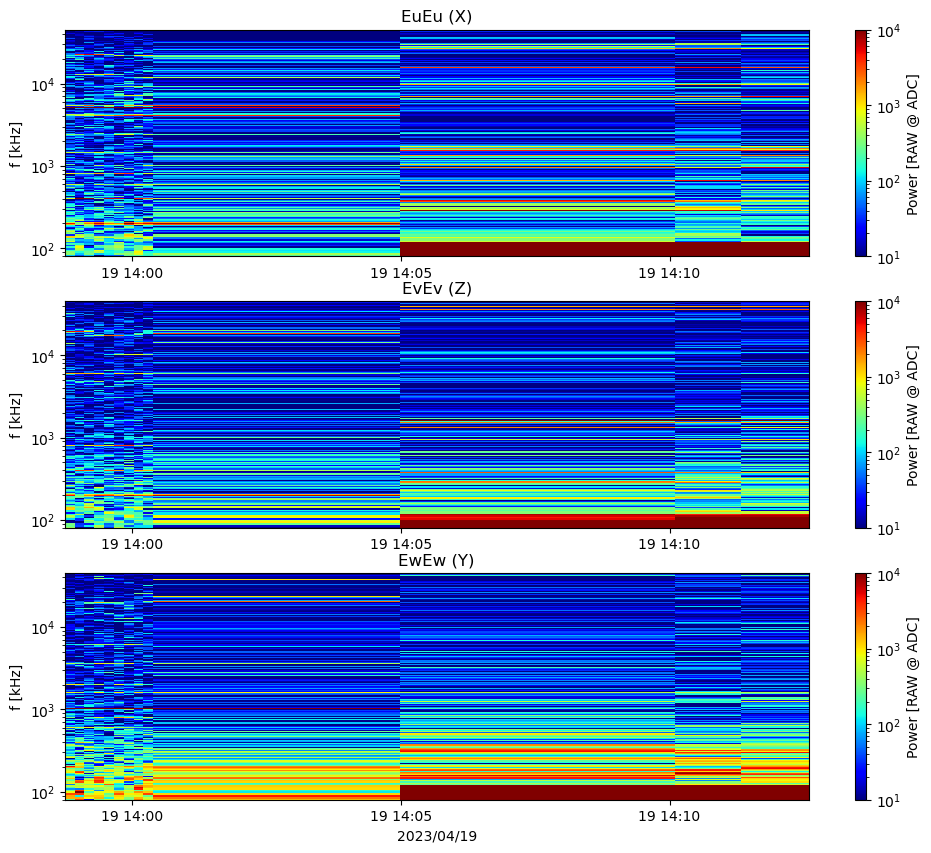

In [30]:
fig = plt.figure(figsize=(12, 10))

ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)

# Plot
p_min0 = p_min+1
p_max0 = p_max-3

# Y-axis
ax1.set_ylim(f_min, f_max)
ax2.set_ylim(f_min, f_max)
ax3.set_ylim(f_min, f_max)
ax1.set_yscale('log')
ax2.set_yscale('log')
ax3.set_yscale('log')
ax1.set_ylabel('f [kHz]')
ax2.set_ylabel('f [kHz]')
ax3.set_ylabel('f [kHz]')

# X-axis
ax1.set_title('EuEu (X)')
ax2.set_title('EvEv (Z)')
ax3.set_title('EwEw (Y)')
date = data.epoch[0]
date = date.strftime('%Y/%m/%d')
ax3.set_xlabel(date)

# Plot
p1 = ax1.pcolormesh(spec.epoch, spec.frequency, spec.Eu_power, norm=colors.LogNorm(vmin=10**p_min0, vmax=10**p_max0), cmap='jet')
p2 = ax2.pcolormesh(spec.epoch, spec.frequency, spec.Ev_power, norm=colors.LogNorm(vmin=10**p_min0, vmax=10**p_max0), cmap='jet')
p3 = ax3.pcolormesh(spec.epoch, spec.frequency, spec.Ew_power, norm=colors.LogNorm(vmin=10**p_min0, vmax=10**p_max0), cmap='jet')

pp1 = fig.colorbar(p1, ax=ax1, orientation="vertical")
pp1.set_label(power_str)
pp2 = fig.colorbar(p2, ax=ax2, orientation="vertical")
pp2.set_label(power_str)
pp3 = fig.colorbar(p3, ax=ax3, orientation="vertical")
pp3.set_label(power_str)

png_fname = work_dir+data_name+'_FT-log.png'
if (spec_mode>0):
    png_fname = work_dir+data_name+'_FT-log_h.png'
# fig.savefig(png_fname)


# Linear: Frequency - Time

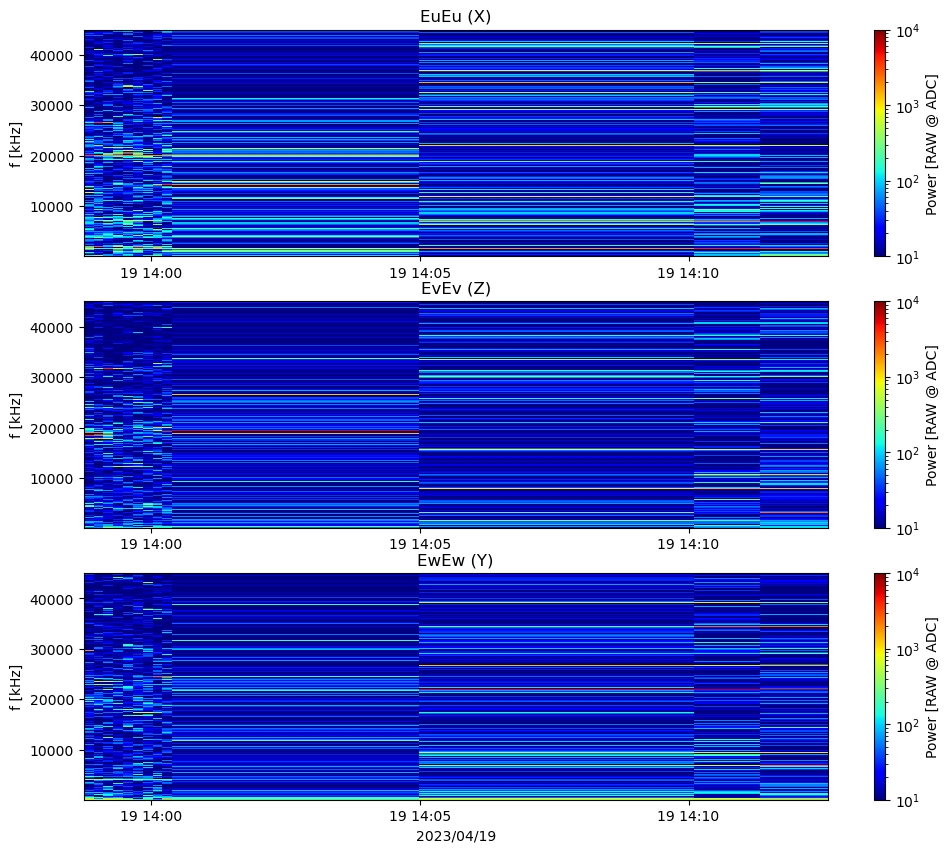

In [31]:
fig = plt.figure(figsize=(12, 10))

ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)

# Plot
p_min0 = p_min+1
p_max0 = p_max-3

# Y-axis
ax1.set_ylim(f_min, f_max)
ax2.set_ylim(f_min, f_max)
ax3.set_ylim(f_min, f_max)
ax1.set_ylabel('f [kHz]')
ax2.set_ylabel('f [kHz]')
ax3.set_ylabel('f [kHz]')

# X-axis
ax1.set_title('EuEu (X)')
ax2.set_title('EvEv (Z)')
ax3.set_title('EwEw (Y)')
date = data.epoch[0]
date = date.strftime('%Y/%m/%d')
ax3.set_xlabel(date)

# Plot
p1 = ax1.pcolormesh(spec.epoch, spec.frequency, spec.Eu_power, norm=colors.LogNorm(vmin=10**p_min0, vmax=10**p_max0), cmap='jet')
p2 = ax2.pcolormesh(spec.epoch, spec.frequency, spec.Ev_power, norm=colors.LogNorm(vmin=10**p_min0, vmax=10**p_max0), cmap='jet')
p3 = ax3.pcolormesh(spec.epoch, spec.frequency, spec.Ew_power, norm=colors.LogNorm(vmin=10**p_min0, vmax=10**p_max0), cmap='jet')

pp1 = fig.colorbar(p1, ax=ax1, orientation="vertical")
pp1.set_label(power_str)
pp2 = fig.colorbar(p2, ax=ax2, orientation="vertical")
pp2.set_label(power_str)
pp3 = fig.colorbar(p3, ax=ax3, orientation="vertical")
pp3.set_label(power_str)

png_fname = work_dir+data_name+'_FT.png'
if (spec_mode>0):
    png_fname = work_dir+data_name+'_FT_h.png'
# fig.savefig(png_fname)

# Analyses

In [32]:
# Antenna Effecitve Length from Fischer+ 2021
gain_dir = './lib/'
gain_name = 'juice_rwi_Effective_length_huvw_freq.csv'
gain_file = gain_dir + gain_name

with open(gain_file) as f:
    reader = csv.reader(f)
    gain_list = [row for row in reader]
gain_data = np.array(gain_list)
gain_data = gain_data.transpose()
gain_freq = np.float16(gain_data[0])*1000
gain_U = np.float16(gain_data[1]) ** 2
gain_V = np.float16(gain_data[2]) ** 2
gain_W = np.float16(gain_data[3]) ** 2

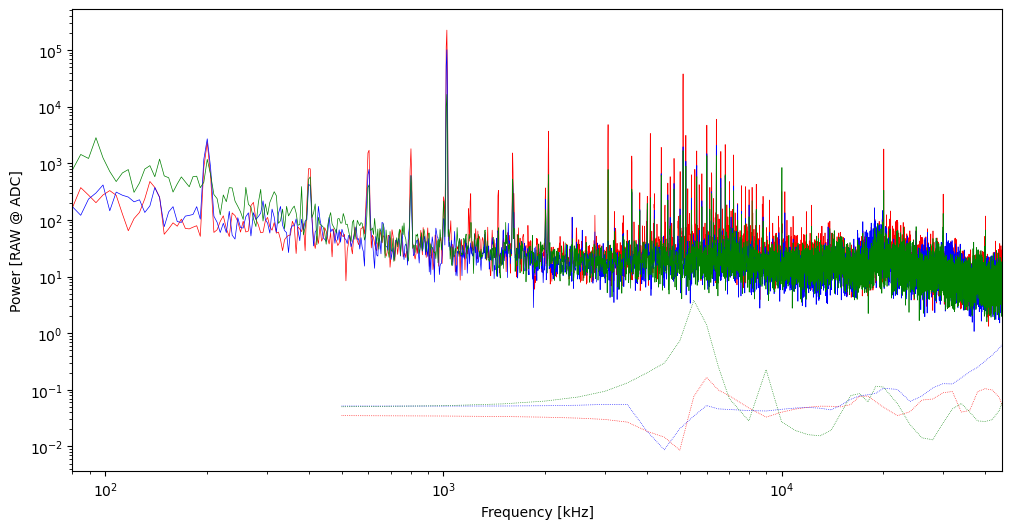

In [33]:
fig = plt.figure(figsize=(12, 6))
plt.plot(gain_freq, gain_U, ':r', linewidth=.5)
plt.plot(gain_freq, gain_V, ':b', linewidth=.5)
plt.plot(gain_freq, gain_W, ':g', linewidth=.5)

plt.plot(freq_med, Eu_med, '-r', linewidth=.5)
plt.plot(freq_med, Ev_med, '-b', linewidth=.5)
plt.plot(freq_med, Ew_med, '-g', linewidth=.5)

plt.xscale('log')
plt.yscale('log')
plt.xlim(f_min, f_max)
# plt.ylim(10**p_min, 10**p_max)

plt.xlabel('Frequency [kHz]')
plt.ylabel(power_str)
plt.ylabel(power_str)
# plt.ylabel('(ANT effective length)^2')

plt.show()
png_fname = work_dir+data_name+'_ant-gain.png'
if (spec_mode>0):
    png_fname = work_dir+data_name+'_ant-gain-h.png'
# fig.savefig(png_fname)

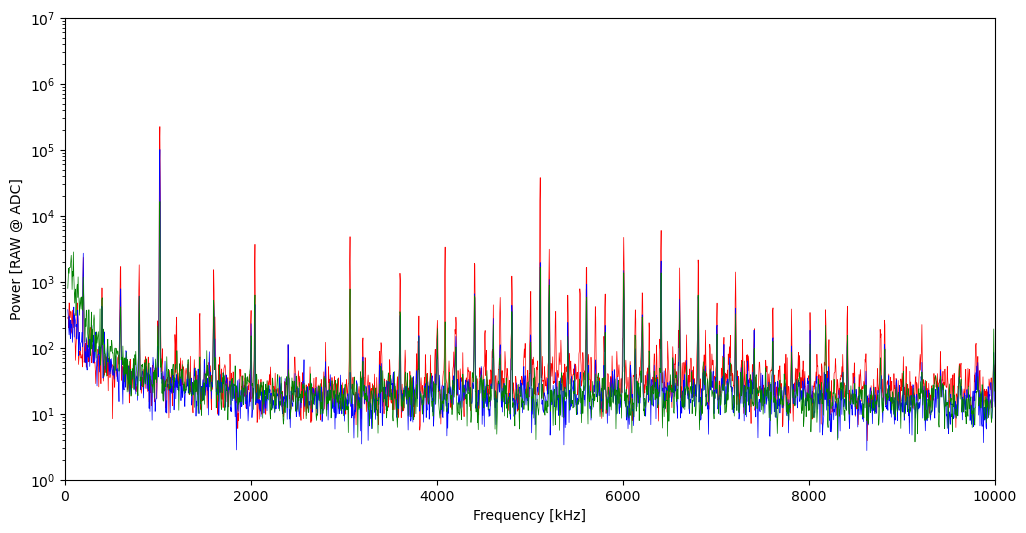

In [34]:
fig = plt.figure(figsize=(12, 6))
ch_min = 0
ch_max = 512*32
f_min0 = 0
f_max0 = 10000

plt.plot(freq_med[ch_min:ch_max+1], Eu_med[ch_min:ch_max+1], '-r', linewidth=.5)
plt.plot(freq_med[ch_min:ch_max+1], Ev_med[ch_min:ch_max+1], '-b', linewidth=.5)
plt.plot(freq_med[ch_min:ch_max+1], Ew_med[ch_min:ch_max+1], '-g', linewidth=.5)
"""
plt.plot(spec.frequency[ch_min:ch_max+1,0], spec.Eu_power[ch_min:ch_max+1,0], '--r', linewidth=1)
plt.plot(spec.frequency[ch_min:ch_max+1,0], spec.Ev_power[ch_min:ch_max+1,0], '--b', linewidth=1)
plt.plot(spec.frequency[ch_min:ch_max+1,0], spec.Ew_power[ch_min:ch_max+1,0], '--g', linewidth=1)
plt.plot(spec.frequency[ch_min:ch_max+1,n_time-1], spec.Eu_power[ch_min:ch_max+1,n_time-1], ':r', linewidth=1)
plt.plot(spec.frequency[ch_min:ch_max+1,n_time-1], spec.Ev_power[ch_min:ch_max+1,n_time-1], ':b', linewidth=1)
plt.plot(spec.frequency[ch_min:ch_max+1,n_time-1], spec.Ew_power[ch_min:ch_max+1,n_time-1], ':g', linewidth=1)
"""

plt.xlabel('Frequency [kHz]')
plt.xlim(f_min0, f_max0)

plt.yscale('log')
plt.ylabel(power_str)
plt.ylim(10**p_min, 10**p_max)

plt.show()
png_fname = work_dir+data_name+'_spec-a.png'
if (spec_mode>0):
    png_fname = work_dir+data_name+'_spec_h-a.png'
# fig.savefig(png_fname)

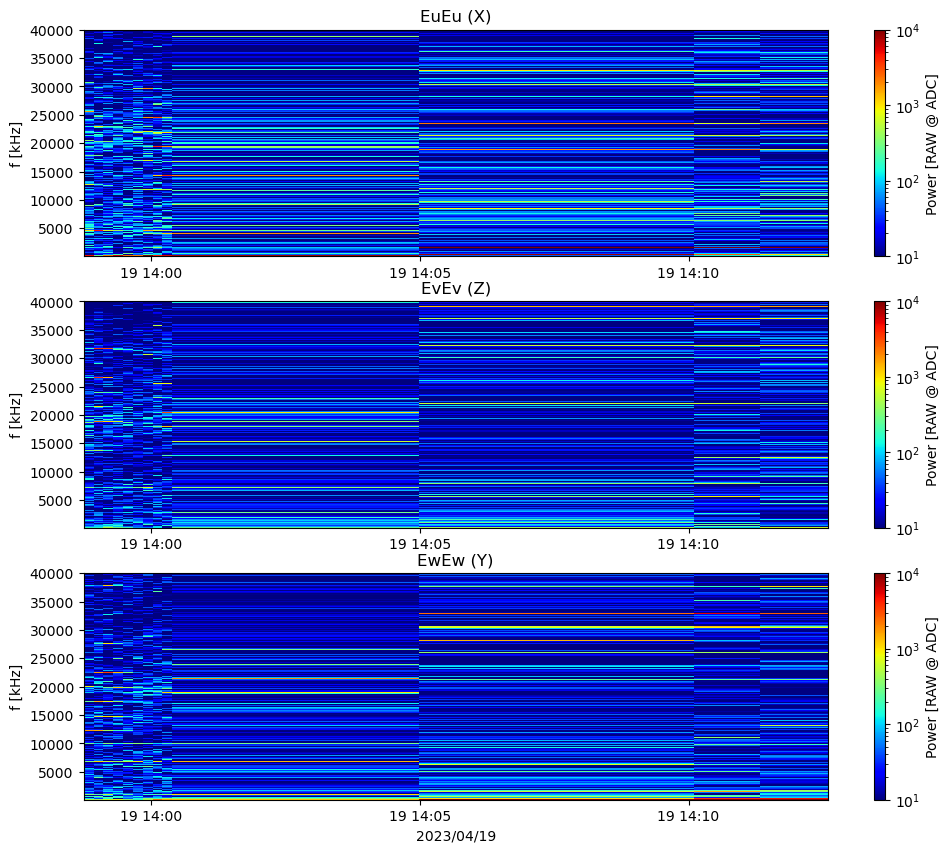

In [35]:
fig = plt.figure(figsize=(12, 10))

ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)

# Plot
p_min0 = p_min+1
p_max0 = p_max-3
"""
x_min = datetime.datetime(2023, 7, 13, 0, 4, 00)
x_max = datetime.datetime(2023, 7, 13, 0, 8, 00)
ax1.set_xlim(x_min, x_max)
ax2.set_xlim(x_min, x_max)
ax3.set_xlim(x_min, x_max)
"""

# Y-axis
ax1.set_ylim(80, 40000)
ax2.set_ylim(80, 40000)
ax3.set_ylim(80, 40000)
# ax1.set_yscale('log')
# ax2.set_yscale('log')
# ax3.set_yscale('log')
ax1.set_ylabel('f [kHz]')
ax2.set_ylabel('f [kHz]')
ax3.set_ylabel('f [kHz]')

# X-axis
ax1.set_title('EuEu (X)')
ax2.set_title('EvEv (Z)')
ax3.set_title('EwEw (Y)')
date = data.epoch[0]
date = date.strftime('%Y/%m/%d')
ax3.set_xlabel(date)

# X: EPOCH
p1 = ax1.pcolormesh(spec.epoch, spec.frequency, spec.Eu_power, norm=colors.LogNorm(vmin=10**p_min0, vmax=10**p_max0), cmap='jet')
p2 = ax2.pcolormesh(spec.epoch, spec.frequency, spec.Ev_power, norm=colors.LogNorm(vmin=10**p_min0, vmax=10**p_max0), cmap='jet')
p3 = ax3.pcolormesh(spec.epoch, spec.frequency, spec.Ew_power, norm=colors.LogNorm(vmin=10**p_min0, vmax=10**p_max0), cmap='jet')

# colbar
pp1 = fig.colorbar(p1, ax=ax1, orientation="vertical")
pp1.set_label(power_str)
pp2 = fig.colorbar(p2, ax=ax2, orientation="vertical")
pp2.set_label(power_str)
pp3 = fig.colorbar(p3, ax=ax3, orientation="vertical")
pp3.set_label(power_str)

png_fname = work_dir+data_name+'_FT-log-a.png'
if (spec_mode>0):
    png_fname = work_dir+data_name+'_FT-log_h-a.png'
# fig.savefig(png_fname)


TypeError: Incompatible X, Y inputs to pcolormesh; see help(pcolormesh)

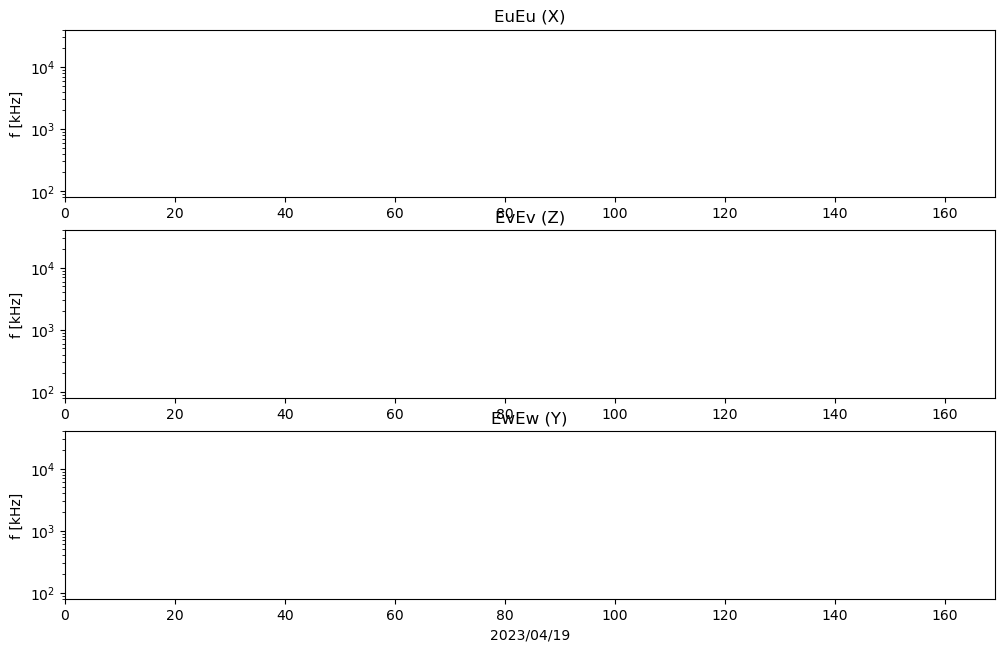

In [36]:
fig = plt.figure(figsize=(12, 10))

ax1 = fig.add_subplot(4, 1, 1)
ax2 = fig.add_subplot(4, 1, 2)
ax3 = fig.add_subplot(4, 1, 3)

# Plot
p_min0 = p_min+1
p_max0 = p_max-3
x_min = 0
x_max = len(data.n_data)
ax1.set_xlim(x_min, x_max)
ax2.set_xlim(x_min, x_max)
ax3.set_xlim(x_min, x_max)

# Y-axis
ax1.set_ylim(80, 40000)
ax2.set_ylim(80, 40000)
ax3.set_ylim(80, 40000)
ax1.set_yscale('log')
ax2.set_yscale('log')
ax3.set_yscale('log')
ax1.set_ylabel('f [kHz]')
ax2.set_ylabel('f [kHz]')
ax3.set_ylabel('f [kHz]')

# X-axis
ax1.set_title('EuEu (X)')
ax2.set_title('EvEv (Z)')
ax3.set_title('EwEw (Y)')
#
date = data.epoch[0]
date = date.strftime('%Y/%m/%d')
ax3.set_xlabel(date)

# Plot
p_min0 = p_min+1.5
p_max0 = p_max-4

# X: n_data
p1 = ax1.pcolormesh(data.n_data, spec.frequency, spec.Eu_power, norm=colors.LogNorm(vmin=10**p_min0, vmax=10**p_max0), cmap='jet')
p2 = ax2.pcolormesh(data.n_data, spec.frequency, spec.Ev_power, norm=colors.LogNorm(vmin=10**p_min0, vmax=10**p_max0), cmap='jet')
p3 = ax3.pcolormesh(data.n_data, spec.frequency, spec.Ew_power, norm=colors.LogNorm(vmin=10**p_min0, vmax=10**p_max0), cmap='jet')

# colbar
pp1 = fig.colorbar(p1, ax=ax1, orientation="vertical")
pp1.set_label(power_str)
pp2 = fig.colorbar(p2, ax=ax2, orientation="vertical")
pp2.set_label(power_str)
pp3 = fig.colorbar(p3, ax=ax3, orientation="vertical")
pp3.set_label(power_str)

# X: n_data
ax4 = fig.add_subplot(4, 1, 4)
p4 = ax4.plot(data.n_data, data.epoch, '-b', linewidth=1)
ax1.set_xlim(x_min, x_max)
ax2.set_xlim(x_min, x_max)
ax3.set_xlim(x_min, x_max)
ax4.set_xlim(x_min, x_max)
pp4 = fig.colorbar(p3, ax=ax4, orientation="vertical")
pp4.set_label(power_str)

png_fname = work_dir+data_name+'_FT-log-a2.png'
if (spec_mode>0):
    png_fname = work_dir+data_name+'_FT-log_h-a2.png'
# fig.savefig(png_fname)

# NORM / DIFF

In [ ]:
fig = plt.figure(figsize=(12, 10))

ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)

# Plot
p_min0 = p_min+1
p_max0 = p_max-4
"""
x_min = datetime.datetime(2023, 7, 13, 0, 4, 00)
x_max = datetime.datetime(2023, 7, 13, 0, 8, 00)
ax1.set_xlim(x_min, x_max)
ax2.set_xlim(x_min, x_max)
ax3.set_xlim(x_min, x_max)
"""

# Y-axis
ax1.set_ylim(80, 45000)
ax2.set_ylim(80, 45000)
ax3.set_ylim(80, 45000)
ax1.set_yscale('log')
ax2.set_yscale('log')
ax3.set_yscale('log')
ax1.set_ylabel('f [kHz]')
ax2.set_ylabel('f [kHz]')
ax3.set_ylabel('f [kHz]')

# X-axis
ax1.set_title('EuEu (X)')
ax2.set_title('EvEv (Z)')
ax3.set_title('EwEw (Y)')
#
date = data.epoch[0]
date = date.strftime('%Y/%m/%d')
ax3.set_xlabel(date)

# X: EPOCH
p1 = ax1.pcolormesh(data.epoch, spec.frequency, spec_bg.Eu_power, norm=colors.LogNorm(vmin=10**p_min0, vmax=10**p_max0), cmap='jet')
p2 = ax2.pcolormesh(data.epoch, spec.frequency, spec_norm.Eu_power, norm=colors.LogNorm(vmin=10**0, vmax=10**.5), cmap='jet')
p3 = ax3.pcolormesh(data.epoch, spec.frequency, spec_diff.Eu_power, norm=colors.LogNorm(vmin=10**1, vmax=10**2.5), cmap='jet')

# colbar
pp1 = fig.colorbar(p1, ax=ax1, orientation="vertical")
pp1.set_label(power_str)
pp2 = fig.colorbar(p2, ax=ax2, orientation="vertical")
pp2.set_label(power_str)
pp3 = fig.colorbar(p3, ax=ax3, orientation="vertical")
pp3.set_label(power_str)

png_fname = work_dir+data_name+'_FT-log-b.png'
if (spec_mode>0):
    png_fname = work_dir+data_name+'_FT-log_h-b.png'
# fig.savefig(png_fname)

In [ ]:
fig = plt.figure(figsize=(12, 10))

ax1 = fig.add_subplot(4, 1, 1)
ax2 = fig.add_subplot(4, 1, 2)
ax3 = fig.add_subplot(4, 1, 3)

# Plot
p_min0 = p_min+1.5
p_max0 = p_max-4
x_min = 0
x_max = len(data.n_data)
ax1.set_xlim(x_min, x_max)
ax2.set_xlim(x_min, x_max)
ax3.set_xlim(x_min, x_max)

# Y-axis
ax1.set_ylim(1000, 4000)
ax2.set_ylim(1000, 4000)
ax3.set_ylim(1000, 4000)
ax1.set_yscale('log')
ax2.set_yscale('log')
ax3.set_yscale('log')
ax1.set_ylabel('f [kHz]')
ax2.set_ylabel('f [kHz]')
ax3.set_ylabel('f [kHz]')

# X-axis
ax1.set_title('EuEu (X)')
ax2.set_title('EvEv (Z)')
ax3.set_title('EwEw (Y)')
#
date = data.epoch[0]
date = date.strftime('%Y/%m/%d')
ax3.set_xlabel(date)

# X: n_data
p1 = ax1.pcolormesh(data.n_data, spec.frequency, spec_bg.Eu_power, norm=colors.LogNorm(vmin=10**p_min0, vmax=10**p_max0), cmap='jet')
p2 = ax2.pcolormesh(data.n_data, spec.frequency, spec_norm.Eu_power, norm=colors.LogNorm(vmin=10**0, vmax=10**.2), cmap='jet')
p3 = ax3.pcolormesh(data.n_data, spec.frequency, spec_diff.Eu_power, norm=colors.LogNorm(vmin=10**1, vmax=10**2.5), cmap='jet')

# colbar
pp1 = fig.colorbar(p1, ax=ax1, orientation="vertical")
pp1.set_label(power_str)
pp2 = fig.colorbar(p2, ax=ax2, orientation="vertical")
pp2.set_label(power_str)
pp3 = fig.colorbar(p3, ax=ax3, orientation="vertical")
pp3.set_label(power_str)

# X: n_data
ax4 = fig.add_subplot(4, 1, 4)
p4 = ax4.plot(data.n_data, data.epoch, '-b', linewidth=1)
ax4.set_xlim(0, len(data.n_data))
pp4 = fig.colorbar(p3, ax=ax4, orientation="vertical")
pp4.set_label(power_str)

png_fname = work_dir+data_name+'_FT-log-b2.png'
if (spec_mode>0):
    png_fname = work_dir+data_name+'_FT-log_h-b2.png'
# fig.savefig(png_fname)

In [ ]:
fig = plt.figure(figsize=(12, 6))
f_min0 = 2000
f_max0 = 4000

n_data0 = 90

print(spec.epoch[90])

plt.plot(spec.frequency[:,n_data0-4], spec.Eu_power[:,n_data0-4], '-b', linewidth=.5)
plt.plot(spec.frequency[:,n_data0-3], spec.Eu_power[:,n_data0-3], '-b', linewidth=.5)
plt.plot(spec.frequency[:,n_data0-2], spec.Eu_power[:,n_data0-2], '-b', linewidth=.5)
plt.plot(spec.frequency[:,n_data0-1], spec.Eu_power[:,n_data0-1], '-g', linewidth=.5)
plt.plot(spec.frequency[:,n_data0], spec.Eu_power[:,n_data0], '-g', linewidth=.5)
plt.plot(spec.frequency[:,n_data0+1], spec.Eu_power[:,n_data0+1], '-g', linewidth=.5)
plt.plot(spec.frequency[:,n_data0+2], spec.Eu_power[:,n_data0+2], '-r', linewidth=.5)
plt.plot(spec.frequency[:,n_data0+3], spec.Eu_power[:,n_data0+3], '-r', linewidth=.5)
plt.plot(spec.frequency[:,n_data0+4], spec.Eu_power[:,n_data0+4], '-r', linewidth=.5)

plt.xlabel('Frequency [kHz]')
plt.xlim(f_min0, f_max0)

plt.yscale('log')
plt.ylabel(power_str)
plt.ylim(10**p_min, 10**p_max)

plt.show()
png_fname = work_dir+data_name+'_spec-a.png'
if (spec_mode>0):
    png_fname = work_dir+data_name+'_spec_h-a.png'
fig.savefig(png_fname)

"""
fig, cal = plt.subplots(figsize=(12, 6))

date = pyspedas.time_string(ex.times[8666])

t = pyspedas.time_string(ex.times[8665])
print(t)
t = pyspedas.time_string(ex.times[8670])
print(t)
t = pyspedas.time_string(ex.times[8675])
print(t)

cal.plot(freq_1d, ex.y[8661], ':b', linewidth=.1)
cal.plot(freq_1d, ex.y[8662], ':b', linewidth=.3)
cal.plot(freq_1d, ex.y[8663], '-b', linewidth=.5)
cal.plot(freq_1d, ex.y[8664], '-b', linewidth=.5)
cal.plot(freq_1d, ex.y[8665], '-g', linewidth=.5)
cal.plot(freq_1d, ex.y[8666], '-g', linewidth=1)
cal.plot(freq_1d, ex.y[8667], '-g', linewidth=1)
cal.plot(freq_1d, ex.y[8668], '-g', linewidth=.5)
cal.plot(freq_1d, ex.y[8669], '-r', linewidth=.5)
cal.plot(freq_1d, ex.y[8670], '-r', linewidth=.5)
cal.plot(freq_1d, ex.y[8671], ':r', linewidth=.3)
cal.plot(freq_1d, ex.y[8672], ':r', linewidth=.1)

cal.set_xlabel('Frequency [kHz]')
cal.set_xscale('log')
cal.set_xlim(1000, 10000)
date = date + '  (Frequency [kHz])'
plt.xlabel(date)

cal.set_yscale('log')
plt.ylabel('Power [mV^2/m^2/Hz]')

plt.show
# png_fname = work_dir+data_name+'_spec-log.png'
# fig.savefig(png_fname)
"""
